# Problem Set 5: Derivatives


# Problem 1: Fee Pricing


In [1]:
import numpy as np
from scipy.stats import norm
from tabulate import tabulate
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
from scipy.interpolate import make_interp_spline, BSpline
import matplotlib.dates as mdates
import statsmodels.api as sm
from sympy.solvers import solve
from sympy import Symbol
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv(r'Data/ToF_2021_PS5-data-1.csv', delimiter = ';', index_col = 'date')
print(data.head(n = 10))

            UBS_CHINA_EQUITY_FUND
date                             
10.08.2018                  17862
13.08.2018                  17784
14.08.2018                  17552
15.08.2018                  17424
16.08.2018                  17015
17.08.2018                  16797
20.08.2018                  16640
21.08.2018                  16840
22.08.2018                  17088
23.08.2018                  17247


In [3]:
# Exogenous Variables
n = 3
S_0 = 1000000
rf_rate = -0.0076
performance_fee = 0.1
binomial_step = 1
months_per_year = 12
days_per_year = 252

# a)

In [4]:
returns = data.pct_change()
returns['Log Return'] = np.nan
returns.rename(columns = {'UBS_CHINA_EQUITY_FUND': 'Return'}, inplace = True)
for i in range(0, len(returns.index)):
    returns.iloc[i, 1] = np.log(1 + returns.iloc[i, 0])
print(returns.head(n=10))

              Return  Log Return
date                            
10.08.2018       NaN         NaN
13.08.2018 -0.004367   -0.004376
14.08.2018 -0.013045   -0.013131
15.08.2018 -0.007293   -0.007319
16.08.2018 -0.023473   -0.023753
17.08.2018 -0.012812   -0.012895
20.08.2018 -0.009347   -0.009391
21.08.2018  0.012019    0.011948
22.08.2018  0.014727    0.014619
23.08.2018  0.009305    0.009262


In [5]:
annualized_mean = days_per_year * returns['Log Return'].mean()
annualized_std = days_per_year**0.5 * returns['Log Return'].std()
u = np.exp(annualized_std)
d = np.exp(-annualized_std)
print(f'Annualized Mean: {round(annualized_mean * 100, 2)}%')
print(f'Annualized Standard Deviation: {round(annualized_std * 100, 2)}%')
print(f'Up-Factor: {round(u, 4)}')
print(f'Down-Factor: {round(d, 4)}')

Annualized Mean: 4.21%
Annualized Standard Deviation: 21.93%
Up-Factor: 1.2452
Down-Factor: 0.8031


# b)

In [6]:
q = (annualized_mean*(1/days_per_year) - np.log(d)) / (np.log(u) - np.log(d))
print(f'Upward Probability: {round(q*100, 4)}%')
print(f'Downward Probability: {100-round(q*100, 4)}%')

Upward Probability: 50.0381%
Downward Probability: 49.9619%


In [7]:
# Period 0
S_0 = 1000000
# Period 1
S_1_up = S_0 * u
S_1_down = S_0 * d
# Period 2
S_2_up_up = S_1_up * u
S_2_up_down = S_1_up * d
S_2_down_up = S_1_down * u
S_2_down_down = S_1_down * d
# Period 3
S_3_up_up_up = S_2_up_up * u
S_3_up_up_down = S_2_up_up * d
S_3_up_down_up = S_2_up_down * u
S_3_up_down_down = S_2_up_down * d
S_3_down_up_up = S_2_down_up * u
S_3_down_up_down = S_2_down_up * d
S_3_down_down_up = S_2_down_down * u
S_3_down_down_down = S_2_down_down * d

In [8]:
# Period 0
print(f'S0: {round(S_0, 2)}')
# Period 1
print(f'S1 (U): {round(S_1_up, 2)}')
print(f'S1 (D): {round(S_1_down, 2)}')
# Period 2
print(f'S2 (UU): {round(S_2_up_up, 2)}')
print(f'S2 (UD): {round(S_2_up_down, 2)}')
print(f'S2 (DU): {round(S_2_down_up, 2)}')
print(f'S2 (DD): {round(S_2_down_down, 2)}')
# Period 3
print(f'S3 (UUU): {round(S_3_up_up_up, 2)}')
print(f'S3 (UUD): {round(S_3_up_up_down, 2)}')
print(f'S3 (UDU): {round(S_3_up_down_up, 2)}')
print(f'S3 (UDD): {round(S_3_up_down_down, 2)}')
print(f'S3 (DUU): {round(S_3_down_up_up, 2)}')
print(f'S3 (DUD): {round(S_3_down_up_down, 2)}')
print(f'S3 (DDU): {round(S_3_down_down_up, 2)}')
print(f'S3 (DDD): {round(S_3_down_down_down, 2)}')

S0: 1000000
S1 (U): 1245219.52
S1 (D): 803071.25
S2 (UU): 1550571.65
S2 (UD): 1000000.0
S2 (DU): 1000000.0
S2 (DD): 644923.44
S3 (UUU): 1930802.08
S3 (UUD): 1245219.52
S3 (UDU): 1245219.52
S3 (UDD): 803071.25
S3 (DUU): 1245219.52
S3 (DUD): 803071.25
S3 (DDU): 803071.25
S3 (DDD): 517919.47


# c)

In [9]:
# Period 1
NPV_1 = 0
if S_1_up > S_0:
    NPV_1 += 1/(1-rf_rate) * q * (S_1_up-S_0) * 0.1
if S_1_down > S_0:
    NPV_1 += 1/(1-rf_rate) * (1-q) * (S_1_down-S_0) * 0.1
print(f'Expected NPV of CFs in Period 1: {round(NPV_1, 2)}')

Expected NPV of CFs in Period 1: 12177.77


In [10]:
# Period 2
NPV_2 = 0
if S_2_up_up > S_1_up:
    NPV_2 += 1/(1-rf_rate)**2 * q**2 * (S_2_up_up-S_1_up) * 0.1
if S_2_up_down > S_1_up:
    NPV_2 += 1/(1-rf_rate)**2 * q * (1-q) * (S_2_up_down-S_1_up) * 0.1
if S_2_down_up > S_0:
    NPV_2 += 1/(1-rf_rate)**2 * q * (1-q) * (S_2_down_up-S_1_down) * 0.1
if S_2_down_down > S_0:
    NPV_2 += 1/(1-rf_rate)**2 * (1-q)**2 * (S_2_down_down-S_1_down) * 0.1
print(f'Expected NPV of CFs in Period 2: {round(NPV_2, 2)}')

Expected NPV of CFs in Period 2: 7530.55


In [11]:
# Period 2
NPV_3 = 0
if S_3_up_up_up > S_2_up_up:
    NPV_3 += 1/(1-rf_rate)**3 * q**3 * (S_3_up_up_up-S_2_up_up) * 0.1
if S_3_up_up_down > S_2_up_up:
    NPV_3 += 1/(1-rf_rate)**3 * q**2 * (1-q) * (S_3_up_up_down-S_2_up_up) * 0.1
if S_3_up_down_up > S_1_up:
    NPV_3 += 1/(1-rf_rate)**3 * q * (1-q) * q * (S_3_up_down_up-S_2_up_down) * 0.1
if S_3_up_down_down > S_1_up:
    NPV_3 += 1/(1-rf_rate)**3 * q * (1-q) * (1-q) * (S_3_up_down_down-S_2_up_down) * 0.1
if S_3_down_up_up > S_2_down_up:
    NPV_3 += 1/(1-rf_rate)**3 * (1-q) * q**2 * (S_3_down_up_up-S_2_down_up) * 0.1
if S_3_down_up_down > S_2_down_up:
    NPV_3 += 1/(1-rf_rate)**3 * (1-q) * q * (1-q) * (S_3_down_up_down-S_2_down_up) * 0.1
if S_3_down_down_up > S_0:
    NPV_3 += 1/(1-rf_rate)**3 * (1-q)**2 * q * (S_3_down_down_up-S_2_down_down) * 0.1
if S_3_down_down_down > S_0:
    NPV_3 += 1/(1-rf_rate)**3 * (1-q)**3 * (S_3_down_down_down-S_2_down_down) * 0.1
print(f'Expected NPV of CFs in Period 3: {round(NPV_3, 2)}')

Expected NPV of CFs in Period 3: 7655.46


# d)

In [12]:
k = 0.1
utility_1 = NPV_1**(1-k) / (1-k)
utility_2 = NPV_2**(1-k) / (1-k)
utility_3 = NPV_3**(1-k) / (1-k)
print(f'Expected Utility from CFs in Period 1: {round(utility_1, 2)}')
print(f'Expected Utility from CFs in Period 2: {round(utility_2, 2)}')
print(f'Expected Utility from CFs in Period 3: {round(utility_3, 2)}')

Expected Utility from CFs in Period 1: 5281.64
Expected Utility from CFs in Period 2: 3426.9
Expected Utility from CFs in Period 3: 3478.02


# e)

In [13]:
c = Symbol('c')
coupon = solve((1/(1+rf_rate) * c + 1/(1+rf_rate)**2 * c + 1/(1+rf_rate)**3 * c)**(1-k) / (1-k) - utility_1 - utility_2 - utility_3, c)[0]
print(f'Utility-Indifferent Fixed Annual Coupon: {round(coupon, 2)}')

Utility-Indifferent Fixed Annual Coupon: 10122.08


# f)

In [15]:
# See Solution Sheet

# Problem 2: Black-Scholes, Combined Strategy

In [16]:
# Exogenous variables

S = 12361.69
sigma = 0.1331
rf = -0.0076
m = 1/12

# a) 

In [17]:
# See Solution Sheet

# b)

In [18]:
Kc = call_strike = 12600
Kp = put_strike = 12100

# Formula for European Call Option (21.3)

#Call_price = S*phi(d1)-(e^(-ym))*Kc*phi(d2)
#Put_price = Kp*e^(-ym)*phi(-d2)-S*phi(-d1)
#S = Spot
#y = risk free
#m = time to maturity
#K = Strike Price
#sigma = volatility of asset

#Call Price
d1_call = (np.log(S/Kc)+(rf+(sigma**2)/2.)*m)/(sigma*np.sqrt(m))
d2_call = d1_call-sigma*np.sqrt(m)

bs_call_price = S*norm.cdf(d1_call)-Kc*np.exp(-rf*m)*norm.cdf(d2_call)

#Put Price
d1_put = (np.log(S/Kp)+(rf+(sigma**2)/2.)*m)/(sigma*np.sqrt(m))
d2_put = d1_put-sigma*np.sqrt(m)

# bs_put_price = Kp*np.exp(-rf*m)-S+bs_call_price
bs_put_price = Kp*np.exp(-rf*m)*norm.cdf(-d2_put)-S*norm.cdf(-d1_put)

print("The option price for a European Call, with Strike 12'600, is: " + str(round(bs_call_price, 2)))
print("The option price for a European Put, with Strike 12'100, is: " + str(round(bs_put_price, 2)))

The option price for a European Call, with Strike 12'600, is: 92.89
The option price for a European Put, with Strike 12'100, is: 87.24


# c)

In [19]:
#The Greeks (Formula found at Remark 22.5)
#Delta
delta_call = norm.cdf(d1_call)
dcall = round((delta_call), 2)
delta_put = -norm.cdf(d1_put)
dput = round((delta_put), 2)
#Gamma
gamma_call = norm.pdf(d1_call) / (S*sigma*np.sqrt(m))
gcall = round((gamma_call), 5)
gamma_put = gamma_call
gput = round((gamma_put), 2)
#Theta
theta_call = (-(S*norm.pdf(d1_call)*sigma)/(2*np.sqrt(m)) - rf*Kc*np.exp(-rf*m)*norm.cdf(d2_call))
tcall = round((theta_call), 2)
theta_put = (-(S*norm.pdf(d1_put)*sigma)/(2*np.sqrt(m)) + rf*Kp*np.exp(-rf*m)*norm.cdf(-d2_put))
tput = round((theta_put), 2)
#Rho
rho_call = (Kc*m*np.exp(-rf*m)*norm.cdf(d2_call))
rcall = round((rho_call), 2)
rho_put = (-Kp*m*np.exp(-rf*m)*norm.cdf(-d2_put))
rput = round((rho_put), 2)
#Vega
vega_call = (S*norm.pdf(d1_call)*np.sqrt(m))
vcall = round((vega_call), 2)
vega_put = (S*norm.pdf(d1_put)*np.sqrt(m))
vput = round((vega_put), 2)

table = [['Greeks', 'Call', 'Put'], ['Delta', dcall, dput], ['Gamma', gcall, dput], ['Theta', tcall, tput], ['Rho', rcall, rput], ['Vega', vcall, vput]]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid', numalign="right"))
 

╒══════════╤═════════╤═════════╕
│ Greeks   │    Call │     Put │
╞══════════╪═════════╪═════════╡
│ Delta    │    0.31 │   -0.71 │
├──────────┼─────────┼─────────┤
│ Gamma    │ 0.00074 │   -0.71 │
├──────────┼─────────┼─────────┤
│ Theta    │ -977.73 │ -999.84 │
├──────────┼─────────┼─────────┤
│ Rho      │  312.19 │ -303.82 │
├──────────┼─────────┼─────────┤
│ Vega     │ 1259.96 │ 1217.29 │
╘══════════╧═════════╧═════════╛


# d)

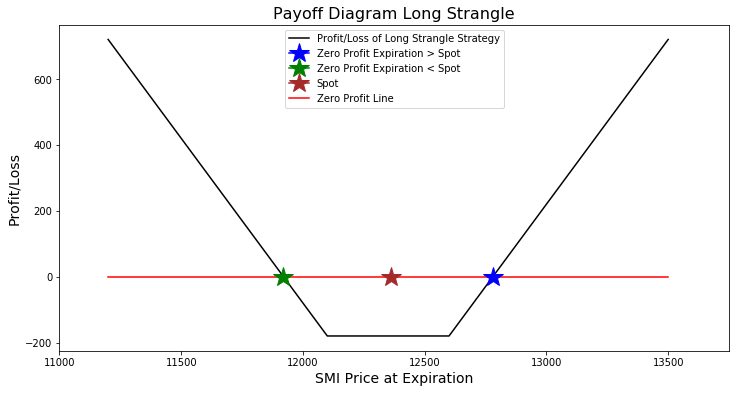

The value of going long 1 Call and 1 Put (ignoring transaction costs) is: 
180.14


In [20]:
expiration = np.arange(11200, 13600, 100)[::-1]

call_profit = []
for i in expiration:
    if Kc <= i:
        j = i-Kc-bs_call_price
    else: j = -bs_call_price
    call_profit.append(j)

put_profit = []
for i in expiration:
    if Kp <= i:
        j = -bs_put_price
    else: j = Kp-i-bs_put_price
    put_profit.append(j)


profits = pd.DataFrame(columns = ['Profit/Loss Call', 'Profit/Loss Put', 'Profit Long Strangle'],  index = expiration)
profits['Profit/Loss Call'] = call_profit
profits['Profit/Loss Put'] = put_profit
profits['Profit Long Strangle'] = profits['Profit/Loss Call'] + profits['Profit/Loss Put']
profits['Zero'] = [0]*24



plt.figure(figsize = (12,6))
plt.plot(expiration, profits['Profit Long Strangle'], color ='black', label ='Profit/Loss of Long Strangle Strategy', zorder=1)
plt.plot(12780.13, 0, color = 'blue', marker='*', label = 'Zero Profit Expiration > Spot', markersize=20.0, zorder=3)
plt.plot(11919.87, 0, color = 'Green', marker='*', label = 'Zero Profit Expiration < Spot', markersize=20.0, zorder=4)
plt.plot(S,0, color='brown', marker='*', label = 'Spot', markersize=20.0, zorder=5)
plt.plot(expiration, profits['Zero'], color='red', linestyle='-', label='Zero Profit Line', zorder=2)
plt.xlim(xmin=11000, xmax=13750)
plt.legend(loc='best')


plt.title('Payoff Diagram Long Strangle', size = 16)
plt.xlabel('SMI Price at Expiration', size = 14)
plt.ylabel('Profit/Loss', size = 14)

plt.show()

print('The value of going long 1 Call and 1 Put (ignoring transaction costs) is: \n' + str(round(bs_call_price + bs_put_price, 2)))


# e)

In [21]:
# The phi(d2) term in the Black- Scholes formula (21.3)–(21.4) is the risk-neutral probability that S_m > K
# calculating the risk-neutral probability that we will make a profit with this strategy:
rn_d1_call = (np.log((S-bs_call_price-bs_put_price)/Kc)+(rf+(sigma**2)/2.)*m)/(sigma*np.sqrt(m))
rn_d2_call = rn_d1_call-sigma*np.sqrt(m)

rn_probability_call = norm.cdf(rn_d2_call)
#print(rn_probability_call)

rn_d1_put = (np.log((S+bs_call_price+bs_put_price)/Kp)+(rf+(sigma**2)/2.)*m)/(sigma*np.sqrt(m))
rn_d2_put = rn_d1_put-sigma*np.sqrt(m)
rn_probability_put = norm.cdf(-rn_d2_put)

print("The risk-neutral probaility that this strategy will generate a profit is: " + str(round(rn_probability_call+rn_probability_put, 2)))

The risk-neutral probaility that this strategy will generate a profit is: 0.36


# f)

In [22]:
# the Value of the portfolio is
# V = vS + M - L
# we assume M = 0 and L = - 1C - 1P given we're long one of each
# becomes V = vS + 1C + 1P 
# given we're looking to be delta neutral need to take the deriv of this wrt S
# so we have v = phi(d1_call) - phi(d1_put)
#delta_call = norm.cdf(d1_call)
#dcall = round((delta_call), 2)
#delta_put = -norm.cdf(d1_put)

v = - delta_call - delta_put
print(str(round(v, 4))+" units of the underlying need to be bought such that the position is delta-neutral")

0.4016 units of the underlying need to be bought such that the position is delta-neutral


# g)

In [23]:
# we want to have a 70% risk neutral probability that at least one of the options is in the money
# given both options contribute equally we want: 1-phi(d2_put) =0.35 and phi(d2_call) =0.35
# corresponding values of the normal distribution are -0.385 and 0.385
#defining d2
d2_p = 0.385
d2_c = -0.385
norm.cdf(d2_c)
#solve formula 21.4 now back to get K
# K = S/exp((d2+sigma*sqrt(m))*sigma*sqrt(m) - (y+sigma**2/2)*m)

0.3501187077652757

In [24]:
S = 12361.69
sigma = 0.1331
y = -0.0076
m = 1/12

Kp_g = S/np.exp((d2_p+sigma*np.sqrt(m))*sigma*np.sqrt(m) - (y+sigma**2/2)*m)
Kc_g = S/np.exp((d2_c+sigma*np.sqrt(m))*sigma*np.sqrt(m) - (y+sigma**2/2)*m)

print("The strike for the call option needs to be set at " + str(round(Kc_g, 2)))
print("The strike for the put option needs to be set at " + str(round(Kp_g, 2)))

The strike for the call option needs to be set at 12528.72
The strike for the put option needs to be set at 12163.48


# h)

In [25]:
#Call Price
d1_call = (np.log(S/Kc_g)+(rf+(sigma**2)/2.)*m)/(sigma*np.sqrt(m))
d2_call = d1_call-sigma*np.sqrt(m)

call_price = S*norm.cdf(d1_call)-Kc_g*np.exp(-rf*m)*norm.cdf(d2_call)

#Put Price
d1_put = (np.log(S/Kp_g)+(rf+(sigma**2)/2.)*m)/(sigma*np.sqrt(m))
d2_put = d1_put-sigma*np.sqrt(m)

put_price = Kp_g*np.exp(-rf*m)*norm.cdf(-d2_put)-S*norm.cdf(-d1_put)

print("The option price for a European Call, with Strike 12528.72, is: " + str(round(call_price, 2)))
print("The option price for a European Put, with Strike 12163.48, is: " + str(round(put_price, 2)))

#calculating the strategy value is
# V = - (-1C - 1P)

V = call_price + put_price
print("The overall strategy value is : " + str(round(V, 2)))

The option price for a European Call, with Strike 12528.72, is: 115.96
The option price for a European Put, with Strike 12163.48, is: 107.91
The overall strategy value is : 223.87
